<a href="https://colab.research.google.com/github/gamecicn/sample_jupyter/blob/main/NLP_FP_LSTM_Emotional_analysis_W2V_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# NLP FP Emotional analysis

In [1]:
# Install
!pip install numpy==1.16.2


     |████████████████████████████████| 17.3MB 199kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.16.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [4]:
# Setup



# All the imports!

import numpy as np
from numpy import array

import tensorflow as tf 
from tensorflow.keras.preprocessing import sequence
from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential

 
# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True


In [5]:
# Mount google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Sklearn import data


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/My Drive/DS_data/ISEAR_clean.csv", sep=",")
df.dropna(inplace=True)

labels = df.emotion.factorize()
labels_index = labels[1]
df['emotion'] = labels[0]

training_data, testing_data, y_train, y_test = train_test_split(df.text, df.emotion, test_size=0.1, random_state=123, shuffle=True)

In [25]:
training_data.head(5)

5302    When I heard that a woman of my community had ...
6550    It was on 9th January 1983 when I received a m...
2031    I was in about Grade 7, I came home from schoo...
3918    A terrible cloud-burst started when we were ca...
1114    [ When after a night of sleeping in another's ...
Name: text, dtype: object

In [26]:
y_train.head(5)

5302    4
6550    3
2031    1
3918    1
1114    3
Name: emotion, dtype: int64

In [27]:
labels_index

Index(['joy', 'fear', 'anger', 'sadness', 'disgust', 'shame', 'guilt'], dtype='object')

## Pre-processing Data

### TF-IDF

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

# extract features
vectorizer1 = TfidfVectorizer(stop_words = "english")
x_train = vectorizer1.fit_transform(training_data)
# Use training data's vocabulary to create test tf-idf matrix
vectorizer2 = TfidfVectorizer(stop_words = "english",vocabulary=vectorizer1.vocabulary_)
x_test = vectorizer2.fit_transform(testing_data)

vocab_size = x_train.shape[1]
review_length = 500

print("vocab_size : {}".format(vocab_size))
'''



'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\n# extract features\nvectorizer1 = TfidfVectorizer(stop_words = "english")\nx_train = vectorizer1.fit_transform(training_data)\n# Use training data\'s vocabulary to create test tf-idf matrix\nvectorizer2 = TfidfVectorizer(stop_words = "english",vocabulary=vectorizer1.vocabulary_)\nx_test = vectorizer2.fit_transform(testing_data)\n\nvocab_size = x_train.shape[1]\nreview_length = 500\n\nprint("vocab_size : {}".format(vocab_size))\n'

### Wrod2Vec

In [31]:
import gensim

print('\nTraining word2vec...')
 

max_sentence_len = max([ len(x) for x in df["text"] ])

word_model = gensim.models.Word2Vec(df["text"], size=100, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

print('\nPreparing the data for LSTM...')

x_train = np.zeros([len(training_data), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(training_data):
  for t, word in enumerate(sentence):
    x_train[i, t] = word2idx(word)
print('x_train shape:', x_train.shape)


x_test = np.zeros([len(testing_data), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(testing_data):
  for t, word in enumerate(sentence):
    x_test[i, t] = word2idx(word)
print('x_test shape:', x_test.shape)




Training word2vec...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


Result embedding shape: (85, 100)

Preparing the data for LSTM...
x_train shape: (6899, 890)
x_test shape: (767, 890)


In [ ]:
# x_train[1]

In [51]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('vocab_size: {}'.format(vocab_size))
print('emdedding_size: {}'.format(emdedding_size))


y_train shape: (6899,)
y_test shape: (767,)
vocab_size: 85
emdedding_size: 100


## Create and build LSTM Recurrent Neural Network

In [53]:
# We begin by defining the a empty stack. We'll use this for building our 
# network, later by layer.
model = tf.keras.models.Sequential()

# The Embedding Layer provides a spatial mapping (or Word Embedding) of all the 
# individual words in our training set. Words close to one another share context 
# and or meaning. This spatial mapping is learning during the training process.

 
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = emdedding_size, # Dimensions to which each words shall be mapped
        weights=[pretrained_weights]
    )
)
 
# Dropout layers fight overfitting and forces the model to learn multiple 
# representations of the same data by randomly disabling neurons in the 
# learning phase.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# We are using a fast version of LSTM whih is optimised for GPUs. This layer 
# looks at the sequence of words in the review, along with their word embeddings
# and uses both of these to determine to sentiment of a given review.
model.add(
    tf.compat.v1.keras.layers.CuDNNLSTM(
        units=emdedding_size  
    )
)

# Add a second dropout layer with the same aim as the first.
model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

# All LSTM units are connected to a single node in the dense layer. A sigmoid 
# activation function determines the output from this node - a value 
# between 0 and 1. Closer to 0 indicates a negative review. Closer to 1 
# indicates a positive review.
model.add(
    tf.keras.layers.Dense(
        units=vocab_size, # Single unit
        activation='softmax' # Sigmoid activation function (output from 0 to 1)
    )
)

# Compile the model
model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy']) # reporting metric

# Display a summary of the models structure
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         8500      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)                8585      
Total params: 97,885
Trainable params: 97,885
Non-trainable params: 0
_________________________________________________________________


In [37]:
#x_train = np.array(x_train)
#y_train = np.array(y_train)
type(x_train)

numpy.ndarray

In [14]:
type(y_train)

pandas.core.series.Series

In [39]:
y_train

5302    4
6550    3
2031    1
3918    1
1114    3
       ..
4062    1
1347    3
3456    3
7535    0
3584    6
Name: emotion, Length: 6899, dtype: int64

## Train the LSTM

In [54]:
# Train the LSTM on the training data
history = model.fit(

    # Training data : features (review) and classes (positive or negative)
    x_train, y_train,
                    
    # Number of samples to work through before updating the 
    # internal model parameters via back propagation. The 
    # higher the batch, the more memory you need.
    batch_size=64, 

    # An epoch is an iteration over the entire training data.
    epochs=5, 
    
    # The model will set apart his fraction of the training 
    # data, will not train on it, and will evaluate the loss
    # and any model metrics on this data at the end of 
    # each epoch.
    validation_split=0.2,
    
    verbose=1
) 

Epoch 1/5
87/87 [==============================] - 13s 152ms/step - loss: 13.2660 - accuracy: 0.0141 - val_loss: 13.2112 - val_accuracy: 0.0000e+00
Epoch 2/5
87/87 [==============================] - 13s 149ms/step - loss: 13.2622 - accuracy: 0.0140 - val_loss: 13.2112 - val_accuracy: 0.0000e+00
Epoch 3/5
87/87 [==============================] - 13s 149ms/step - loss: 13.2620 - accuracy: 0.0121 - val_loss: 13.2112 - val_accuracy: 0.0000e+00
Epoch 4/5
87/87 [==============================] - 13s 150ms/step - loss: 13.2619 - accuracy: 0.0145 - val_loss: 13.2112 - val_accuracy: 0.0000e+00
Epoch 5/5
87/87 [==============================] - 13s 148ms/step - loss: 13.2618 - accuracy: 0.0118 - val_loss: 13.2112 - val_accuracy: 0.0000e+00


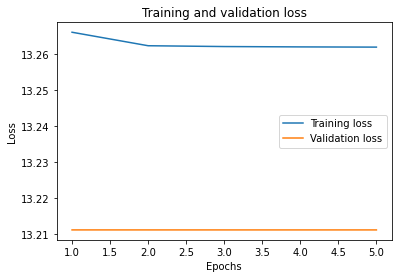

In [55]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

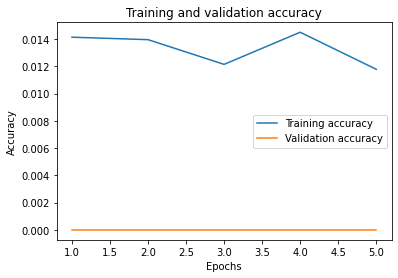

In [56]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [45]:
predicted_classes

array([70, 70, 70, ..., 70, 70, 70])

In [57]:
# Get Model Predictions for test data
from sklearn.metrics import classification_report

predicted_classes = model.predict_classes(x_test)
print(classification_report(y_test, predicted_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      98.0
           1       0.00      0.00      0.00     100.0
           2       0.00      0.00      0.00     109.0
           3       0.00      0.00      0.00     118.0
           4       0.00      0.00      0.00     116.0
           5       0.00      0.00      0.00     110.0
           6       0.00      0.00      0.00     116.0
          49       0.00      0.00      0.00       0.0

    accuracy                           0.00     767.0
   macro avg       0.00      0.00      0.00     767.0
weighted avg       0.00      0.00      0.00     767.0



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
